<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: Юрий Исаков и Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>  Практика. Идентификация пользователя с помощью логистической регрессии

Тут мы воспроизведем парочку бенчмарков нашего соревнования и вдохновимся побить третий бенчмарк, а также остальных участников. Веб-формы для отправки ответов тут не будет, ориентир – [leaderboard](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard) соревнования.

In [1]:
import pickle

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

### 1. Загрузка и преобразование данных
Зарегистрируйтесь на [Kaggle](www.kaggle.com), если вы не сделали этого раньше, зайдите на [страницу](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования и скачайте данные. Первым делом загрузим обучающую и тестовую выборки и посмотрим на данные.

In [2]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv("../../data/alice/train_sessions.csv", index_col="session_id")
test_df = pd.read_csv("../../data/alice/test_sessions.csv", index_col="session_id")

# приведем колонки time1, ..., time10 к временному формату
times = ["time%s" % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by="time1")

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


В обучающей выборке содержатся следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target – целевая переменная, 1 для сессий Элис, 0 для сессий других пользователей
    
Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [3]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ["site%s" % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype("int")
test_df[sites] = test_df[sites].fillna(0).astype("int")

# загрузим словарик сайтов
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(
    list(site_dict.keys()), index=list(site_dict.values()), columns=["site"]
)
print(u"всего сайтов:", sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

In [4]:
# наша целевая переменная
y_train = train_df["target"]

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

Для самой первой модели будем использовать только посещенные сайты в сессии (но не будем обращать внимание на временные признаки). За таким выбором данных для модели стоит такая идея:  *у Элис есть свои излюбленные сайты, и чем чаще вы видим эти сайты в сессии, тем выше вероятность, что это сессия Элис и наоборот.*

Подготовим данные, из всей таблицы выберем только признаки `site1, site2, ... , site10`. Напомним, что пропущенные значения заменены нулем. Вот как выглядят первые строки таблицы:

In [5]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Сессии представляют собой последовательность индексов сайтов и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии. Это делается в две строчки:

In [6]:
from scipy.sparse import csr_matrix

In [7]:
csr_matrix?

Init signature: csr_matrix(arg1, shape=None, dtype=None, copy=False)
Docstring:     
Compressed Sparse Row matrix

This can be instantiated in several ways:
    csr_matrix(D)
        with a dense matrix or rank-2 ndarray D

    csr_matrix(S)
        with another sparse matrix S (equivalent to S.tocsr())

    csr_matrix((M, N), [dtype])
        to construct an empty matrix with shape (M, N)
        dtype is optional, defaulting to dtype='d'.

    csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
        where ``data``, ``row_ind`` and ``col_ind`` satisfy the
        relationship ``a[row_ind[k], col_ind[k]] = data[k]``.

    csr_matrix((data, indices, indptr), [shape=(M, N)])
        is the standard CSR representation where the column indices for
        row i are stored in ``indices[indptr[i]:indptr[i+1]]`` and their
        corresponding values are stored in ``data[indptr[i]:indptr[i+1]]``.
        If the shape parameter is not supplied, the matrix dimensions
        are inferred 

In [8]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(
    (
        [1] * sites_flatten.shape[0],
        sites_flatten,
        range(0, sites_flatten.shape[0] + 10, 10),
    )
)[:, 1:]

In [9]:
X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

In [10]:
X_train_sparse.shape, y_train.shape

((253561, 48371), (253561,))

Еще один плюс использования разреженных матриц в том, что для них имеются специальные реализации как матричных операций, так и алгоритмов машинного обучения, что подчас позволяет ощутимо ускорить операции за счет особенностей структуры данных. Это касается и логистической регрессии. Вот теперь у нас все готово для построения нашей первой модели.

### 2. Построение первой модели

Итак, у нас есть алгоритм и данные для него, построим нашу первую модель, воспользовавшись релизацией [логистической регрессии](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета `sklearn` с параметрами по умолчанию. Первые 90% данных будем использовать для обучения (обучающая выборка отсортирована по времени), а оставшиеся 10% для проверки качества (validation). 

**Напишите простую функцию, которая будет возвращать качество модели на отложенной выборке, и обучите наш первый классификатор**.

In [11]:
def get_auc_lr_valid(X, y, C=1.0, ratio=0.9, seed=17):
    """
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    """
    train_len = int(X.shape[0]*ratio)
    X_train_def = X[:train_len]
    y_train_def = y[:train_len]
    X_test_def = X[train_len:]
    y_test_def = y[train_len:]
    logit_model = LogisticRegression(C=C, random_state=seed, n_jobs=-1)
    logit_model.fit(X_train_def, y_train_def)
    logit_pred = logit_model.predict_proba(X_test_def)[:, 1]
    return roc_auc_score(y_test_def, logit_pred)
    

**Посмотрите, какой получился ROC AUC на отложенной выборке.**

In [12]:
get_auc_lr_valid(X_train_sparse, y_train)

0.9197951046350004

Будем считать эту модель нашей первой отправной точкой (baseline). Для построения модели для прогноза на тестовой выборке **необходимо обучить модель заново уже на всей обучающей выборке** (пока наша модель обучалась лишь на части данных), что повысит ее обобщающую способность:

In [13]:
# функция для записи прогнозов в файл
def write_to_submission_file(
    predicted_labels, out_file, target="target", index_label="session_id"
):
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(1, predicted_labels.shape[0] + 1),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

**Обучите модель на всей выборке, сделайте прогноз для тестовой выборки и сделайте посылку в соревновании**.

In [14]:
first_submit_model = LogisticRegression(n_jobs=-1)
first_submit_model.fit(X_train_sparse, y_train)

LogisticRegression(n_jobs=-1)

In [15]:
first_submit_predict = first_submit_model.predict_proba(X_test_sparse)[:, 1]

In [16]:
# write_to_submission_file(first_submit_predict, "first_submit_predict.csv")

Если вы выполните эти действия и загрузите ответ на [странице](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования, то воспроизведете первый бенчмарк "Logit".

### 3. Улучшение модели, построение новых признаков

Создайте такой признак, который будет представлять собой число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом, мы будем учитывать помесячный [линейный тренд](http://people.duke.edu/~rnau/411trend.htm) за весь период предоставленных данных.

In [17]:
new_feature_train = pd.DataFrame(index=train_df.index)
new_feature_test = pd.DataFrame(index=test_df.index)

In [18]:
new_feature_train['year_month'] = train_df['time1'].apply(lambda ts: ts.year*100+ts.month)
new_feature_test['year_month'] = test_df['time1'].apply(lambda ts: ts.year*100+ts.month)

In [19]:
new_feature_test.head()

,year_month
session_id,
1,201410
2,201407
3,201412
4,201411
5,201405


Добавьте новый признак, предварительно отмасштабировав его с помощью `StandardScaler`, и снова посчитайте ROC AUC на отложенной выборке.

In [20]:
new_feature_test['year_month'].values.reshape(1,-1)

array([[201410, 201407, 201412, ..., 201405, 201405, 201411]], dtype=int64)

In [21]:
scaler = StandardScaler()

scaler.fit(new_feature_train['year_month'].values.reshape(-1,1))

new_feature_train['year_month_scal'] = scaler.transform(new_feature_train['year_month'].values.reshape(-1,1))
new_feature_test['year_month_scal'] = scaler.transform(new_feature_test['year_month'].values.reshape(-1,1))

In [22]:
X_train_sparse_new_feat = csr_matrix(hstack([X_train_sparse, new_feature_train["year_month_scal"].values.reshape(-1,1)]))
X_test_sparse_new_feat = csr_matrix(hstack([X_test_sparse, new_feature_test["year_month_scal"].values.reshape(-1,1)]))

In [23]:
get_auc_lr_valid(X_train_sparse_new_feat,y_train)

0.9198903563591923

In [24]:
# second_submit_model = LogisticRegression(n_jobs=-1)
# second_submit_model.fit(X_train_sparse_new_feat, y_train)
# second_submit_predict = second_submit_model.predict_proba(X_test_sparse_new_feat)[:, 1]
# write_to_submission_file(second_submit_predict, "second_submit_predict.csv")

**Добавьте два новых признака: start_hour и morning.**

Признак `start_hour` – это час в который началась сессия (от 0 до 23), а бинарный признак `morning` равен 1, если сессия началась утром и 0, если сессия началась позже (будем считать, что утро это если `start_hour равен` 11 или меньше).

**Посчитйте ROC AUC на отложенной выборке для выборки с:**
- сайтами, `start_month` и `start_hour`
- сайтами, `start_month` и `morning`
- сайтами, `start_month`, `start_hour` и `morning`

In [25]:
train_df['time1'].head()

session_id
21669    2013-01-12 08:05:57
54843    2013-01-12 08:37:23
77292    2013-01-12 08:50:13
114021   2013-01-12 08:50:17
146670   2013-01-12 08:50:20
Name: time1, dtype: datetime64[ns]

In [26]:
train_df['time1'].iloc[500], train_df['time1'].iloc[10].dayofweek

(Timestamp('2013-02-12 08:33:17'), 5)

In [27]:
new_feature_train['month'] = train_df['time1'].apply(lambda ts: ts.month)
new_feature_test['month'] = test_df['time1'].apply(lambda ts: ts.month)
new_feature_train['hour'] = train_df['time1'].apply(lambda ts: ts.hour)
new_feature_test['hour'] = test_df['time1'].apply(lambda ts: ts.hour)

In [28]:
new_feature_train['morning'] = train_df['time1'].apply(lambda ts: 1 if ts.hour <=11 else 0 )
new_feature_test['morning'] = test_df['time1'].apply(lambda ts: 1 if ts.hour <=11 else 0)

In [29]:
new_feature_train['day_of_week'] = train_df['time1'].apply(lambda ts: ts.dayofweek)
new_feature_test['day_of_week'] = test_df['time1'].apply(lambda ts: ts.dayofweek)

In [30]:
# new_feature_train['weekend'] = train_df['time1'].apply(lambda ts: ts.dayofweek)
# new_feature_test['weekend'] = test_df['time1'].apply(lambda ts: ts.dayofweek)

In [31]:
new_feature_train.head()

,year_month,year_month_scal,month,hour,morning,day_of_week
session_id,,,,,,
21669,201301,-1.744405,1,8,1,5
54843,201301,-1.744405,1,8,1,5
77292,201301,-1.744405,1,8,1,5
114021,201301,-1.744405,1,8,1,5
146670,201301,-1.744405,1,8,1,5


In [32]:
scaler.fit(new_feature_train['month'].values.reshape(-1,1))

new_feature_train['month_scal'] = scaler.transform(new_feature_train['month'].values.reshape(-1,1))
new_feature_test['month_scal'] = scaler.transform(new_feature_test['month'].values.reshape(-1,1))

In [33]:
X_train_sparse_new_feat = csr_matrix(hstack([X_train_sparse, new_feature_train["month_scal"].values.reshape(-1,1)]))
X_test_sparse_new_feat = csr_matrix(hstack([X_test_sparse, new_feature_test["month_scal"].values.reshape(-1,1)]))

In [34]:
scaler.fit(new_feature_train['hour'].values.reshape(-1,1))

new_feature_train['hour_scal'] = scaler.transform(new_feature_train['hour'].values.reshape(-1,1))
new_feature_test['hour_scal'] = scaler.transform(new_feature_test['hour'].values.reshape(-1,1))

In [35]:
scaler.fit(new_feature_train['day_of_week'].values.reshape(-1,1))

new_feature_train['day_of_week_scal'] = scaler.transform(new_feature_train['day_of_week'].values.reshape(-1,1))
new_feature_test['day_of_week_scal'] = scaler.transform(new_feature_test['day_of_week'].values.reshape(-1,1))

In [36]:
new_feature_train[["day_of_week","day_of_week_scal"]]

,day_of_week,day_of_week_scal
session_id,,
21669,5,1.682905
54843,5,1.682905
77292,5,1.682905
114021,5,1.682905
146670,5,1.682905
...,...,...
12224,2,-0.179911
164438,2,-0.179911
12221,2,-0.179911


In [37]:
X_train_sparse_new_feat = csr_matrix(hstack([X_train_sparse, new_feature_train[['year_month_scal',
                                                                                "month_scal",
                                                                                "hour_scal",
                                                                                'morning',
                                                                                'day_of_week_scal']]]))
X_test_sparse_new_feat = csr_matrix(hstack([X_test_sparse, new_feature_test[['year_month_scal',
                                                                             "month_scal",
                                                                             "hour_scal",
                                                                             'morning',
                                                                             'day_of_week_scal']]]))

In [38]:
X_test_sparse_new_feat

<82797x48376 sparse matrix of type '<class 'numpy.float64'>'
	with 805927 stored elements in Compressed Sparse Row format>

In [39]:
get_auc_lr_valid(X_train_sparse_new_feat,y_train)

0.9686191609636394

In [40]:
# fourth_submit_model = LogisticRegression(n_jobs=-1)
# fourth_submit_model.fit(X_train_sparse_new_feat, y_train)
# fourth_submit_predict = fourth_submit_model.predict_proba(X_test_sparse_new_feat)[:, 1]
# write_to_submission_file(fourth_submit_predict, "fourth_submit_predict.csv")

### 4. Подбор коэффицициента регуляризации

Итак, мы ввели признаки, которые улучшают качество нашей модели по сравнению с первым бейслайном. Можем ли мы добиться большего значения метрики? После того, как мы сформировали обучающую и тестовую выборки, почти всегда имеет смысл подобрать оптимальные гиперпараметры -- характеристики модели, которые не изменяются во время обучения. Например, на 3 неделе вы проходили решающие деревья, глубина дерева это гиперпараметр, а признак, по которому происходит ветвление и его значение -- нет. В используемой нами логистической регрессии веса каждого признака изменяются и во время обучения находится их оптимальные значения, а коэффициент регуляризации остается постоянным. Это тот гиперпараметр, который мы сейчас будем оптимизировать.

Посчитайте качество на отложенной выборке с коэффициентом регуляризации, который по умолчанию `C=1`:

In [95]:
def get_auc_lr_valid_2(X, y, C, ratio=0.75, seed=17):
    """
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    """
    train_len = int(X.shape[0]*ratio)
    X_train_def = X[:train_len]
    y_train_def = y[:train_len]
    X_test_def = X[train_len:]
    y_test_def = y[train_len:]
    logit_model = LogisticRegression(C=C, random_state=seed, n_jobs=-1)
    logit_model.fit(X_train_def, y_train_def)
    logit_pred = logit_model.predict_proba(X_test_def)[:, 1]
    return roc_auc_score(y_test_def, logit_pred)

In [42]:
get_auc_lr_valid_2(X_train_sparse_new_feat,y_train)

0.9420665563395398

In [43]:
# 1.00000000e-03 = 0.9610654426140817
# 2.78255940e-03 = 0.9668040948278465
# 7.74263683e-03 = 0.9708283669597582
# 2.15443469e-02 = 0.9734217498783313


# 5.99484250e-02 = 0.9739842030072373


# 1.66810054e-01 = 0.9728159730650465
# 4.64158883e-01 = 0.9705558957043435
# 1.29154967e+00 = 0.9681576957958817
# 3.59381366e+00 = 0.9658025176645908
# 1.00000000e+01 = 0.9630605963995754



Постараемся побить этот результат за счет оптимизации коэффициента регуляризации. Возьмем набор возможных значений C и для каждого из них посчитаем значение метрики на отложенной выборке.

Найдите `C` из `np.logspace(-3, 1, 10)`, при котором ROC AUC на отложенной выборке максимален. 

In [44]:
np.logspace(-3, 1, 10)

array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
grid = {"C":np.logspace(-3, 1, 10), "penalty":["l1","l2"]}

logreg = LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train_sparse_new_feat,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Наконец, обучите модель с найденным оптимальным значением коэффициента регуляризации и с построенными признаками `start_hour`, `start_month` и `morning`. Если вы все сделали правильно и загрузите это решение, то повторите второй бенчмарк соревнования.

In [47]:
# fifth_submit_model = LogisticRegression(n_jobs=-1, C=5.99484250e-02)
# fifth_submit_model.fit(X_train_sparse_new_feat, y_train)
# fifth_submit_predict = fifth_submit_model.predict_proba(X_test_sparse_new_feat)[:, 1]
# write_to_submission_file(fifth_submit_predict, "fifth_submit_predict.csv")

Cross-validation

In [48]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

In [49]:
# skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=17)

# c_values = np.logspace(-3, 3, 50)

# logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
# logit_searcher.fit(X_train_sparse_new_feat, y_train)

In [50]:
# logit_searcher.C_

In [51]:
# eighth_submit_predict=logit_searcher.predict_proba(X_test_sparse_new_feat)[:, 1]
# write_to_submission_file(eighth_submit_predict, "eighth_submit_predict.csv")

In [52]:
# seventh_submit_predict=logit_searcher.predict_proba(X_test_sparse_new_feat)[:, 1]
# write_to_submission_file(seventh_submit_predict, "seventh_submit_predict.csv")

In [53]:
# sixth_submit_model = LogisticRegression(n_jobs=-1, C=3.59381366)
# sixth_submit_model.fit(X_train_sparse_new_feat, y_train)
# sixth_submit_predict = sixth_submit_model.predict_proba(X_test_sparse_new_feat)[:, 1]
# write_to_submission_file(sixth_submit_predict, "sixth_submit_predict.csv")

In [54]:
logit_searcher.scores_

NameError: name 'logit_searcher' is not defined

In [59]:
train_df['time2'].iloc[300] - train_df['time1'].iloc[300]


Timedelta('0 days 00:20:02')

In [ ]:
train_df.head()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy");

In [ ]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy")
plt.xlim((0, 20));

In [88]:
new_feature_train['first_session_duration'] = (train_df['time2']-train_df['time1']).apply(lambda ts: ts.seconds)
new_feature_test['first_session_duration'] = (test_df['time2']-test_df['time1']).apply(lambda ts: ts.seconds)

In [89]:
new_feature_train['first_session_duration_scal'] = scaler.transform(new_feature_train['first_session_duration'].values.reshape(-1,1))
new_feature_test['first_session_duration_scal'] = scaler.transform(new_feature_test['first_session_duration'].values.reshape(-1,1))

In [94]:
X_train_sparse_new_feat_sec = csr_matrix(hstack([X_train_sparse_new_feat, new_feature_train[['first_session_duration_scal']]]))
X_test_sparse_new_feat_sec = csr_matrix(hstack([X_test_sparse_new_feat, new_feature_test[['first_session_duration_scal']]]))

In [96]:
get_auc_lr_valid_2(X_train_sparse_new_feat_sec, y_train, C=5.99484250e-02)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [102]:
new_feature_test['first_session_duration'].isna().value_counts()

False    81308
True      1489
Name: first_session_duration, dtype: int64

In [115]:
new_feature_test['first_session_duration'].fillna(-1, inplace=True)

In [116]:
new_feature_test['first_session_duration'].isna().value_counts()

False    82797
Name: first_session_duration, dtype: int64

In [117]:
new_feature_train['first_session_duration'].fillna(-1, inplace=True)

In [118]:
new_feature_train['first_session_duration'].isna().value_counts()

False    253561
Name: first_session_duration, dtype: int64

In [119]:
new_feature_train['first_session_duration_scal'] = scaler.transform(new_feature_train['first_session_duration'].values.reshape(-1,1))
new_feature_test['first_session_duration_scal'] = scaler.transform(new_feature_test['first_session_duration'].values.reshape(-1,1))

In [120]:
X_train_sparse_new_feat_sec = csr_matrix(hstack([X_train_sparse_new_feat, new_feature_train[['first_session_duration_scal']]]))
X_test_sparse_new_feat_sec = csr_matrix(hstack([X_test_sparse_new_feat, new_feature_test[['first_session_duration_scal']]]))

In [121]:
get_auc_lr_valid_2(X_train_sparse_new_feat_sec, y_train, C=5.99484250e-02)

0.9449123499447211

In [122]:
ninth_submit_model = LogisticRegression(n_jobs=-1, C=5.99484250e-02)
ninth_submit_model.fit(X_train_sparse_new_feat_sec, y_train)
ninth_submit_predict = ninth_submit_model.predict_proba(X_test_sparse_new_feat_sec)[:, 1]
write_to_submission_file(ninth_submit_predict, "ninth_submit_predict.csv")

In [123]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

In [128]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-3, 3,)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_train_sparse_new_feat_sec, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.0min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.1min finished
C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionCV(Cs=array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
       2.81176870e-01, 3.72...
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, verbose=1)

In [129]:
logit_searcher.C_

array([6.25055193])

In [130]:
import matplotlib.pyplot as plt

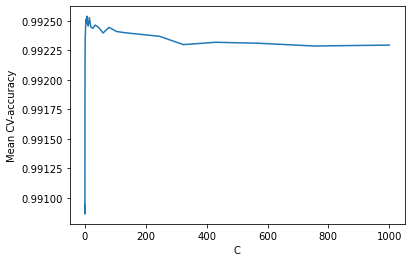

In [131]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy");

In [132]:
get_auc_lr_valid_2(X_train_sparse_new_feat_sec, y_train, 6.25055193)

0.9364945286515856

In [134]:
tenth_submit_predict=logit_searcher.predict_proba(X_test_sparse_new_feat_sec)[:, 1]
write_to_submission_file(tenth_submit_predict, "tenth_submit_predict.csv")

In [135]:
from sklearn.neighbors import KNeighborsClassifier

In [136]:
model_knn = KNeighborsClassifier()

In [144]:
def get_auc_lr_valid_3_knn(X, y, ratio=0.75):
    """
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    """
    train_len = int(X.shape[0]*ratio)
    X_train_def = X[:train_len]
    y_train_def = y[:train_len]
    X_test_def = X[train_len:]
    y_test_def = y[train_len:]
    knn_model = KNeighborsClassifier(n_jobs=-1)
    knn_model.fit(X_train_def, y_train_def)
    knn_pred = knn_model.predict_proba(X_test_def)[:, 1]
    return roc_auc_score(y_test_def, knn_pred)

In [145]:
get_auc_lr_valid_3_knn(X_train_sparse_new_feat_sec, y_train)

0.6662797831310285